In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, concatenate
)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
df = pd.read_csv('data/socal2.csv')
df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [3]:
df = df[:4000]

In [4]:
tabular_features = ['n_citi', 'bed', 'bath', 'sqft']
target = 'price'

In [5]:
X_tabular = df[tabular_features]
y = df[target]

In [6]:
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

In [7]:
def load_images(image_ids, img_size=(224, 224)):
    images = []
    for image_id in image_ids:
        img_path = f'data/socal_pics/{image_id}.jpg'
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

X_images = load_images(df['image_id'])

In [8]:
X_train_images, X_test_images, X_train_tabular, X_test_tabular, y_train, y_test = train_test_split(
    X_images, X_tabular_scaled, y, test_size=0.2, random_state=42
)

In [9]:
# Image branch (CNN)
image_input = Input(shape=(224, 224, 3), name="image_input")
x = Conv2D(32, (3, 3), activation="relu")(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
image_branch = Dense(64, activation="relu")(x)

In [10]:
# Tabular data branch (fully connected network)
tabular_input = Input(shape=(len(tabular_features),), name="tabular_input")
y = Dense(128, activation="relu")(tabular_input)
y = Dropout(0.5)(y)
y = Dense(64, activation="relu")(y)

In [11]:
# Combine both branches
combined = concatenate([image_branch, y])
z = Dense(128, activation="relu")(combined)
z = Dropout(0.5)(z)
z = Dense(1, activation="linear")(z)  # Output layer for price prediction

In [12]:
model = Model(inputs=[image_input, tabular_input], outputs=z)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
history = model.fit(
    x=[X_train_images, X_train_tabular], 
    y=y_train,
    validation_data = ([X_test_images, X_test_tabular], y_test),
    epochs=100,
    batch_size=16
)

Epoch 1/100
200/200 [==============================] - 7s 25ms/step - loss: 277001142272.0000 - mae: 390596.2812 - val_loss: 183662968832.0000 - val_mae: 344920.1875
Epoch 2/100
200/200 [==============================] - 5s 23ms/step - loss: 204229935104.0000 - mae: 333919.1875 - val_loss: 170781523968.0000 - val_mae: 288047.5938
Epoch 3/100
200/200 [==============================] - 5s 23ms/step - loss: 184993005568.0000 - mae: 320409.7188 - val_loss: 163394437120.0000 - val_mae: 277640.3750
Epoch 4/100
200/200 [==============================] - 5s 23ms/step - loss: 175898984448.0000 - mae: 311173.6250 - val_loss: 144077193216.0000 - val_mae: 267260.7500
Epoch 5/100
200/200 [==============================] - 5s 23ms/step - loss: 155884732416.0000 - mae: 293487.5938 - val_loss: 128114745344.0000 - val_mae: 263846.0000
Epoch 6/100
200/200 [==============================] - 4s 22ms/step - loss: 143478177792.0000 - mae: 277953.0312 - val_loss: 136623718400.0000 - val_mae: 260892.0625
Epoc

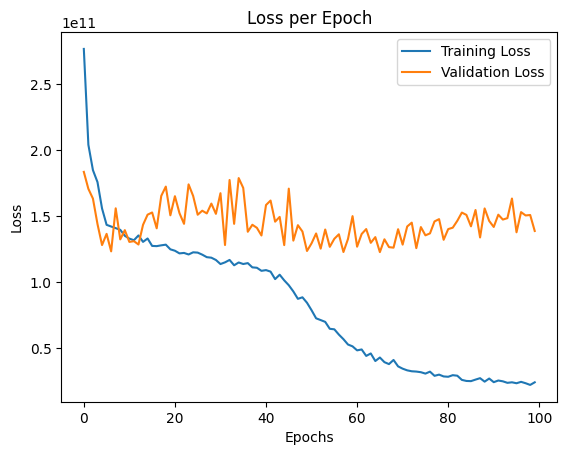

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
results = model.evaluate([X_test_images, X_test_tabular], y_test)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")
results

25/25 [==============================] - 1s 11ms/step - loss: 138807803904.0000 - mae: 268490.2188
Test Loss: 138807803904.0, Test MAE: 268490.21875


[138807803904.0, 268490.21875]

In [16]:
from sklearn.metrics import r2_score
y_pred = model.predict([X_test_images, X_test_tabular])
r2_score(y_test, y_pred)


25/25 [==============================] - 1s 10ms/step


0.16338789463043213